#Importing dataset from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDER_DIR = '/content/Frames_Word_Level.zip'
FOLDER_DIR_DRIVE = '/content/drive/My Drive/Mini_Project/Dataset'                # Path containing Dataset

In [ ]:
!pip install mediapipe sklearn matplotlib opencv-python==4.5.3.56

     |████████████████████████████████| 32.7 MB 72.0 MB/s 
     |████████████████████████████████| 49.9 MB 42 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# 1) Import and Install Libraries 



In [ ]:
import cv2
import numpy as np
import os        # for making file path tasks easier 
from matplotlib import pyplot as plt
import time      # to get sleep between 
import mediapipe as mp

#2) Keypoints using MP Holistic [ Data Preprocessing ]

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model ( to make detections , downloading or leveraging the model )
mp_drawing = mp.solutions.drawing_utils # Drawing utilities  ( to draw them , makes drawing keypoints on our face easier )

##Function for Detection

In [ ]:

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable ( saves memory )
    results = model.process(image)                 # Make prediction   # Image is the frame from openCV and this line is performing detection 
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

##Function for Drawing Landmarks on images

In [ ]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

###Improvising the landmark drawing function for better color 

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

##Function to extract keypoints and store in numpy array

In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])                                 # 1662 coordinates / values per frame

##Function to generate keypoints from images and save to folders

In [ ]:
def generate_keypoints(file_path,save_dir): 
  import cv2
  import numpy as np
  # from google.colab.patches import cv2_imshow
  # Create a VideoCapture object and read from input file
  # If the input is the camera, pass 0 instead of the video file name 
  cap = cv2.VideoCapture(file_path)                                                                     # accessing the path location of individual frame(image) and making it an object     
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")

  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:    # accessing the mediapipe model by passing initiating parameters 
  # It tracks the keypoints from initial detection
      # i = 0
      while cap.isOpened():                                                                             # Looping through frames , looks like a video 
        # Read feed. 
        ret, frame = cap.read()                                                                         # Reading in BGR frame(numpy array describing the image) from the file location 
        if ret == True:
          # Make detections
          image, results = mediapipe_detection(frame, holistic)                                           # passed single frame , result = x,y,z coordinates of landmark for pose , etc 
          print(results)
          # Draw landmarks
          draw_landmarks(image, results)                                    
          keypoints = extract_keypoints(results)                                                            # got all the landmarks in a flattened numpy array format 
          draw_styled_landmarks(frame, results) 
          plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          np.save(save_dir, keypoints)                                                                      # saved the numpy array keypoint with filename save_dir in the mentioned location
          # numpy array for evry frame in each folder/label got saved

          # Break gracefully
          if cv2.waitKey(10) & 0xFF == ord('q'):
              break
        else:
          break
  # When everything done, release the capture object
  cap.release()
  # Closes all the frames
  cv2.destroyAllWindows()

In [ ]:
from pathlib import Path
import re
labels = os.listdir(FOLDER_DIR_DRIVE)
paths = Path(FOLDER_DIR_DRIVE).glob('**/*.jpg')     
print(labels)

['YOU', 'UNDERSTAND', 'LIKE', 'I_ME_MINE_MY', 'CLASS', 'HEART', 'AFRAID', 'GOOD', 'FOOD', 'ANGRY', 'LOVE']


In [ ]:
SAVE_DIR = '/content/drive/MyDrive/Mini_Project/Dataset_numpy'

##Function to collect images frame by frame from drive

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

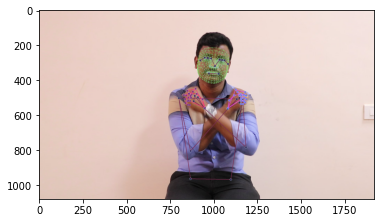

In [ ]:
from pathlib import Path                                                        # Path object from pathlib
import re

labels = os.listdir(FOLDER_DIR_DRIVE)                                           # returning list of names of all the files/folders in the mentioned directory 
paths = Path(FOLDER_DIR_DRIVE).glob('**/*.jpg')                                 # returning list of all the files / folders of matching kind
for label in labels:
  i = 0
  try:
      os.makedirs(os.path.join(SAVE_DIR,str(label)))                            # IN SAVE_DIR directory , all subdirectories titled label name are made with every iteration in loop
  except:
      pass                                                                      # Execute this when an error is made 
  # os.makedirs(os.path.join(SAVE_DIR,str(label)))                                 
  for image in os.listdir(os.path.join(FOLDER_DIR_DRIVE,str(label))):           # os.listdir(os.path.join(FOLDER_DIR_DRIVE,str(label))) = list of all the files in every label folder residing in Dataset
    path = os.path.join(FOLDER_DIR_DRIVE,str(label),str(image))                 # path = path of individual file present (accessed using os.path.join module )
    save_dir = os.path.join(SAVE_DIR,str(label),str(i))                         # path of a individual folder/file in the 'label' directory that'll store the numpy array values of an individual image or frame 
    generate_keypoints(path,save_dir)                                           # passing the path of individual frame and the path of individual file to store its corresponding numpy array value
    i += 1
    

In [ ]:
def remove_empty_folders(path_abs):
    walk = list(os.walk(path_abs))               # returns the tuple for directory in the directory tree
    for path, _, _ in walk[::-1]:               
        if len(os.listdir(path)) == 0:           # Checking whether the folder is empty 
            os.rmdir(path)                       # removing the folder 

In [ ]:
remove_empty_folders(SAVE_DIR)

#3) Creating Input and Target Variable for Neural Network

In [ ]:
labels = os.listdir(SAVE_DIR)              

In [ ]:
labels_list = ['YOU','I_ME_MINE_MY','UNDERSTAND','FOOD','LIKE','LOVE','CLASS','HEART','AFRAID','ANGRY','GOOD']

In [ ]:
label_map_list = {key:value for value, key in enumerate(labels_list)}  # enumerating(storing counters) the list and storing it as key value pairs
# enumerate = returns counters , value , counter in value
print(label_map_list)                 

{'YOU': 0, 'I_ME_MINE_MY': 1, 'UNDERSTAND': 2, 'FOOD': 3, 'LIKE': 4, 'LOVE': 5, 'CLASS': 6, 'HEART': 7, 'AFRAID': 8, 'ANGRY': 9, 'GOOD': 10}


In [ ]:
images_1 , targets_1 = [],[]                                                   

In [ ]:
for label in labels_list:
  array = []
  for i in os.listdir(os.path.join(SAVE_DIR,str(label))):     # os.listdir is returning list of all the files from the particular label folder ( list of 0.npy , 1.npy etc)
    array = np.load(os.path.join(SAVE_DIR,str(label),str(i))) # array = numpy array stored in particular file (0.npy) of particular folder(label) 
    images_1.append(array)                                    # saving the array(numpy value) into list for particular i
    targets_1.append(label_map_list[label])                   # saving the target(value in label_map_list) i number of times for every label
# as for one label target is same and is should be assigned to each frame(numpy value)(i)
#(images_1) gets appended with 1662 values 282 times , hence shape = 282 , 1662(r,c)


In [ ]:
len(targets_1)  
# Total 282 npy files in all label folders
# 11 labels = 11 categories / 11 classes 
# these classes are stored in taregts_1 with some repitions according to how much frames we have for these classes

282

In [ ]:
np.save('/content/drive/MyDrive/Mini_Project/images_1.npy',images_1)            
np.save('/content/drive/MyDrive/Mini_Project/targets_1.npy',targets_1)

In [ ]:
images_1 = np.load('/content/drive/MyDrive/Mini_Project/images_1.npy')         
targets_1 = np.load('/content/drive/MyDrive/Mini_Project/targets_1.npy')


In [ ]:
from sklearn.model_selection import train_test_split                            
from tensorflow.keras.utils import to_categorical                               

In [ ]:
X = np.array(images_1)    # input for model ( numpy array containing all the positions of the landmarks)

In [ ]:
y = to_categorical(targets_1).astype(int)   # performed one hot encoding on targets_1 and stored in y 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, shuffle = True)

#4) Model Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
model = Sequential()

model.add(Dense(512, activation='tanh',input_shape = X_train[1].shape))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(11, activation='softmax'))                                        

In [ ]:
import tensorflow as tf
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision()])

##Using callback object to solve overfitting

In [ ]:
import tensorflow as tf

# Implement callback function to stop training
# when accuracy reaches ACCURACY_THRESHOLD
ACCURACY_THRESHOLD = 0.99

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [ ]:
history = model.fit(X_train,y_train,epochs=1000,batch_size=32,callbacks=[callbacks], shuffle = True, verbose=2)

Epoch 1/1000
6/6 - 1s - loss: 1.9678 - accuracy: 0.2899 - precision: 0.3750 - 983ms/epoch - 164ms/step
Epoch 2/1000
6/6 - 0s - loss: 1.6415 - accuracy: 0.3728 - precision: 0.4074 - 49ms/epoch - 8ms/step
Epoch 3/1000
6/6 - 0s - loss: 1.6429 - accuracy: 0.3491 - precision: 0.4167 - 51ms/epoch - 8ms/step
Epoch 4/1000
6/6 - 0s - loss: 1.6585 - accuracy: 0.3018 - precision: 0.3478 - 46ms/epoch - 8ms/step
Epoch 5/1000
6/6 - 0s - loss: 1.6016 - accuracy: 0.4556 - precision: 0.0000e+00 - 52ms/epoch - 9ms/step
Epoch 6/1000
6/6 - 0s - loss: 1.6012 - accuracy: 0.3846 - precision: 0.0000e+00 - 56ms/epoch - 9ms/step
Epoch 7/1000
6/6 - 0s - loss: 1.5934 - accuracy: 0.4201 - precision: 0.4464 - 53ms/epoch - 9ms/step
Epoch 8/1000
6/6 - 0s - loss: 1.6050 - accuracy: 0.3491 - precision: 0.5082 - 66ms/epoch - 11ms/step
Epoch 9/1000
6/6 - 0s - loss: 1.5607 - accuracy: 0.4142 - precision: 0.7273 - 52ms/epoch - 9ms/step
Epoch 10/1000
6/6 - 0s - loss: 1.5395 - accuracy: 0.4793 - precision: 0.5000 - 53ms/epoc

##Plotting Accuracy v/s Epoch Graph

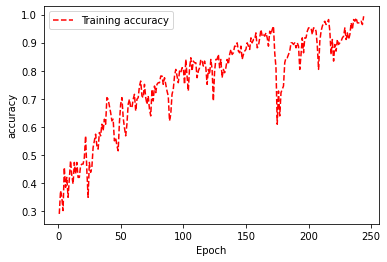

In [ ]:
training_accuracy = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)
# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
# plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show();

In [ ]:
epoch_count

range(1, 245)

In [ ]:
score = model.evaluate(X_test,y_test,batch_size=8)

15/15 [==============================] - 0s 2ms/step - loss: 2.1624 - accuracy: 0.7168 - precision: 0.7156


##Predicting on Test Data

In [ ]:
yhat = model.predict(X_test)

In [ ]:
yhat

array([[9.77080941e-01, 6.06324375e-06, 3.88299100e-07, ...,
        1.35925973e-07, 4.73798636e-08, 6.96459645e-03],
       [9.08798754e-01, 3.56636924e-08, 7.71664854e-05, ...,
        1.58012824e-06, 1.55737638e-04, 4.63474281e-02],
       [3.82072756e-08, 9.69191015e-01, 2.33442016e-11, ...,
        7.45517954e-16, 1.47635590e-14, 4.09501730e-08],
       ...,
       [1.63987835e-07, 9.99113977e-01, 7.68439620e-13, ...,
        2.85168531e-17, 1.42790898e-15, 3.10732631e-08],
       [7.86026895e-01, 1.46861794e-07, 1.15238635e-07, ...,
        3.23655229e-07, 3.16482851e-06, 2.25595541e-05],
       [4.53993259e-03, 3.84117094e-09, 1.40155049e-03, ...,
        8.67381004e-06, 3.17028571e-05, 1.37003444e-04]], dtype=float32)

In [ ]:
yhat.shape

(113, 11)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
yhat

[0,
 0,
 1,
 1,
 6,
 3,
 0,
 0,
 6,
 8,
 3,
 4,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 7,
 0,
 5,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 4,
 1,
 1,
 1,
 0,
 0,
 0,
 3,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 0,
 9,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 6,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 4,
 0,
 0,
 3,
 1,
 0,
 1,
 10,
 0,
 1,
 3,
 1,
 1,
 9,
 1,
 1,
 0,
 3,
 0,
 1,
 1,
 0,
 3,
 1,
 1,
 1,
 0,
 6,
 0,
 1,
 1,
 9,
 1,
 3,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 3]

In [ ]:
ytrue

[0,
 0,
 1,
 1,
 8,
 3,
 0,
 0,
 6,
 8,
 3,
 9,
 6,
 3,
 3,
 0,
 0,
 1,
 0,
 5,
 0,
 5,
 0,
 3,
 10,
 3,
 1,
 1,
 0,
 0,
 1,
 1,
 9,
 1,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 3,
 1,
 5,
 1,
 2,
 1,
 3,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 8,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 3,
 1,
 1,
 9,
 1,
 0,
 1,
 3,
 0,
 1,
 1,
 0,
 9,
 1,
 1,
 1,
 0,
 8,
 0,
 1,
 1,
 5,
 1,
 5,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0]

##Confusion Matrix and Accuracy Score

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
cf_matrix=multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

0.7168141592920354

In [ ]:
label = ['YOU','I_ME_MINE_MY','UNDERSTAND','FOOD','LIKE','LOVE','CLASS','HEART','AFRAID','ANGRY','GOOD']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

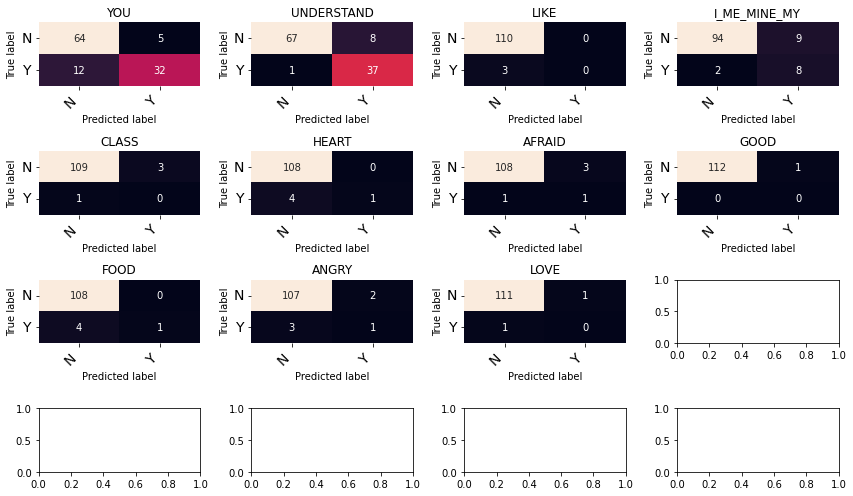

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cf_matrix, labels):
     print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()